In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
pd.set_option('use_inf_as_na', True)
from collections import Counter
import pickle

/var/folders/sp/wlr6xm2979l8vx6kjh2z1dk00000gn/T/ipykernel_7991/3610104393.py:8: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('use_inf_as_na', True)


In [5]:
raw_data = pd.read_pickle(r'dataset.pkl')

data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [6]:
def f(x):

    if x > 0.01:
        return 1
    elif x < -0.025:

        return -1
    

    else:
    
        return 0

In [7]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

In [8]:
df_1 = data.loc['2000-01-01':'2003-01-01']
df_valid = data.loc['2003-04-01':'2003-07-01']
df_test = data.loc['2003-10-01':'2004-01-01']

In [9]:
train_1 = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                    'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
test = df_test.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [10]:
train_1_stock_returns = df_1['next_period_return']
valid_stock_returns = df_valid['next_period_return']
test_stock_returns = df_test['next_period_return']

y_1 = df_1['rel_performance']
y_valid = df_valid['rel_performance']
y_test = df_test['rel_performance']

y_1 = y_1.values
y_valid = y_valid.values
y_test = y_test.values

In [11]:
import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

In [10]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,5)
    ada_n_estimators = trial.suggest_int('n_estimators', 10,100,step=10)
    ada_learning_rate = trial.suggest_float('learning_rate',0.1,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    preds = ada_clf.predict(val)
    accuracy = ada_clf.score(val,val_labels)
 
    return accuracy

In [20]:
study = optuna.create_study(direction="maximize")
from functools import partial

In [12]:
%%time
study.optimize(partial(objective,train=train_1,labels=y_1,val=valid,val_labels=y_valid,val_rets=valid_stock_returns), n_trials=20,n_jobs=-1)

CPU times: total: 1h 21min 52s
Wall time: 22min 31s


In [16]:
y_valid * valid_stock_returns

date
2003-04-01    0.278251
2003-04-01    0.259396
2003-04-01    0.247837
2003-04-01    0.747637
2003-04-01    0.155639
                ...   
2003-06-27    0.155993
2003-06-30    0.206234
2003-06-30    0.000000
2003-06-30    0.532442
2003-07-01    0.140787
Name: next_period_return, Length: 827, dtype: float64

In [19]:
study.best_params

NameError: name 'study' is not defined

In [21]:
best_params = {'n_estimators': 40, 'learning_rate': 0.1}

In [22]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),**best_params)

In [23]:
start_dates = [pd.to_datetime('2000-01-01') + pd.DateOffset(months = 3 * i) for i in range(62)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

In [24]:
def adaboost_feat_importances(m, df):
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)


In [27]:
%%time
optimal_features = []


for i in range(len(training_data)):
    print(i)
    profits = []
    feat=[]

    ada_clf.fit(training_data[i],training_labels[i])
    fi = adaboost_feat_importances(ada_clf,training_data[i])
    features = fi[fi['feat_imp'] > 0.011]
    optimal_features.append(features)
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
CPU times: user 14min 2s, sys: 17.2 s, total: 14min 19s
Wall time: 14min 40s


In [28]:
optimal_features[9]['cols'].values

array(['dvpspq', 'ibadj12', 'cf_yield', 'epspi12', 'ptpmq',
       'debt_assetsq', 'rd_saleq', 'oepf12', 'fcf_yield',
       'book_value_yield', 'curr_ratioq', 'evmq', 'opmadq', 'epsfiq',
       'oepsxy', 'atq', 'epspxq', 'epsx12', 'epsfi12', 'gpmq'],
      dtype=object)

In [29]:
P_L = []
x = [1]
ret = []

for i in range(len(optimal_features)-2):

        ada_clf.fit(training_data[i][optimal_features[i]['cols'].values],training_labels[i])
        pred_i = ada_clf.predict(test_data[i][optimal_features[i]['cols'].values])
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

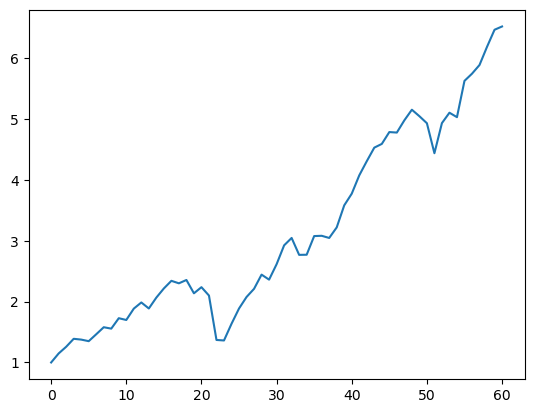

In [30]:
plt.plot(x);

In [31]:
SPY = pd.read_pickle(r'SPY_cum_ret.pkl')
SPY = SPY.loc['2003-07-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

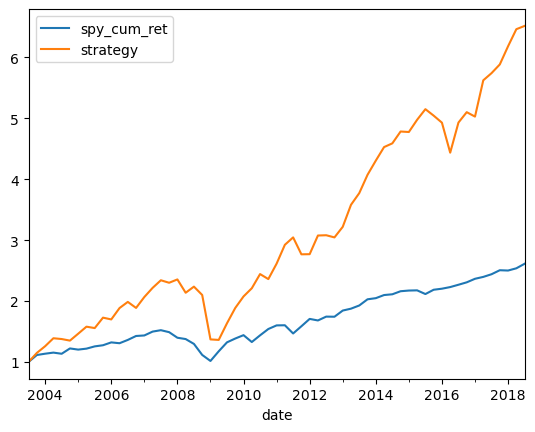

In [32]:
SPY.plot();

In [33]:
SPY

,spy_cum_ret,strategy
date,,
2003-09-30,1.000000,1.000000
2003-12-31,1.113539,1.148144
2004-03-31,1.135013,1.257932
2004-06-30,1.152844,1.388816
2004-09-30,1.134023,1.375828
...,...,...
2017-09-30,2.440106,5.742677
2017-12-31,2.505941,5.885479
2018-03-31,2.500747,6.184020


In [34]:
SPY = SPY.iloc[1:].resample('A').bfill()

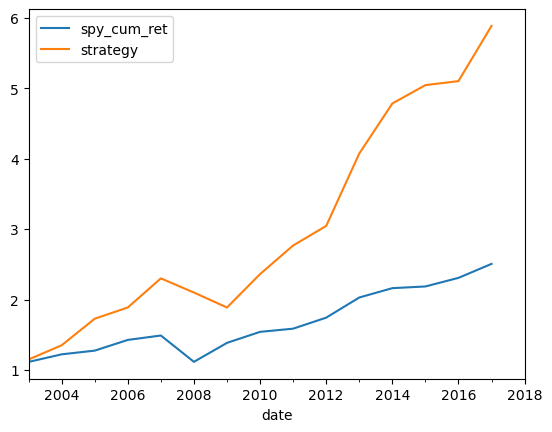

In [35]:
SPY.plot();

In [36]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/(strategy_std)
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.9715017415355042


In [37]:
strategy_std

0.34830726958132063

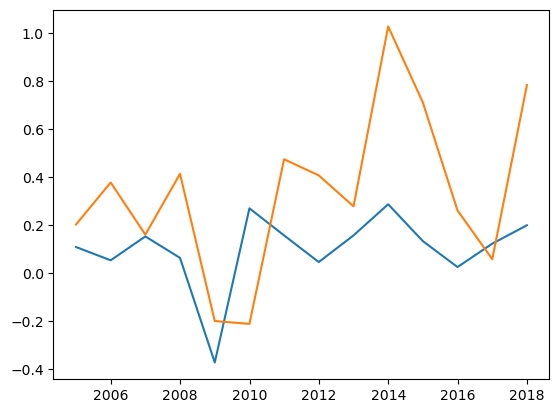

In [38]:
plt.plot((SPY['spy_cum_ret']-1).diff());
plt.plot((SPY['strategy'] - 1).diff());

In [39]:
spy_mean_ret = (SPY['spy_cum_ret'] - 1).diff().mean()
spy_std = (SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',spy_mean_ret/(spy_std))

SP Sharpe Ratio:  0.633278084803048


In [40]:
x[-1]

6.518130609234239

In [41]:
avr = np.exp(np.log(x[-1])/15.) - 1
print('Average annual return: ',avr)

Average annual return:  0.13311730086086926


In [42]:
SPY['spy_cum_ret'][-2]

2.505940999999999

In [43]:
sp_avr = np.exp(np.log(SPY['spy_cum_ret'][-2])/15) - 1
print('SPY average annual return: ', sp_avr)

SPY average annual return:  0.06315859883751296


In [44]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:-1]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:-1]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

1.1146253965410033

In [45]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

0.7658404103248014

In [46]:
alpha = np.mean(residual_ret)
alpha

0.22752350245955183

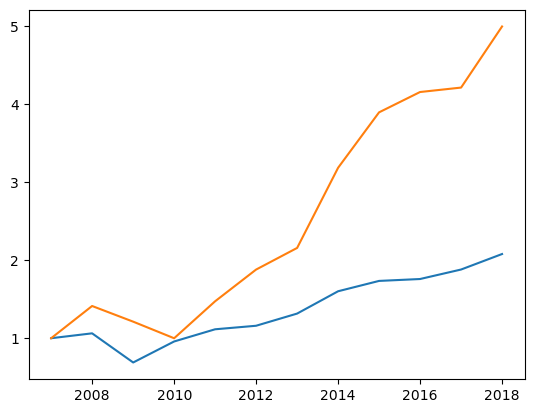

In [47]:
starting_year='2006'
a = SPY.loc[starting_year]['spy_cum_ret'].values
b = SPY.loc[starting_year]['strategy'].values
plt.plot(SPY.loc[starting_year:]['spy_cum_ret'] - a + 1);
plt.plot(SPY.loc[starting_year:]['strategy'] - b + 1);

In [53]:
def max_drawdown(returns):
        local_max = [n for n in range(len(returns)-1) if ((n==0) and (returns[0] > returns[1])) or 
           ((n > 0) and  (returns[n-1]<returns[n]) and (returns[n+1]<returns[n]))] 
        
        local_min = [n for n in range(1,len(returns)) if ((n == len(returns)-1) and (returns[-1] < returns[-2])) or
                (returns[n-1]>returns[n]) and (returns[n+1]>returns[n])]
        
        def next_local_min(n):
            if [m for m in local_min if m > n]:
                return [m for m in local_min if m > n][0]
            else: return None
        
        drawdowns = [(n,next_local_min(n)) for n in local_max]
        drawdown_values = [returns[n] - returns[m] for (n,m) in drawdowns if m != None]
        if drawdown_values:
            return  np.max(drawdown_values)
        else: return 0.0

In [54]:
(SPY.loc[starting_year:]['spy_cum_ret'] - a + 1).values

array([1.      , 1.062668, 0.688883, 0.958275, 1.114603, 1.159812,
       1.316196, 1.602417, 1.735057, 1.759361, 1.881241, 2.079963,
            nan])

In [55]:
max_drawdown((SPY.loc[starting_year:]['spy_cum_ret'] - a + 1).values)

0.37378500000000003

In [56]:
max_drawdown((SPY.loc[starting_year:]['strategy'] - b + 1).values)

0.4137213065861638

In [57]:
def max_dd(returns):
    i = np.argmax(np.maximum.accumulate(returns) - returns)
    j = np.argmax(returns[:i])
    plt.plot(returns);
    plt.plot([i, j], [returns[i], returns[j]], 'o', color='Red', markersize=10)
    print(np.abs(returns[j] - returns[i]))

0.4137213065861638


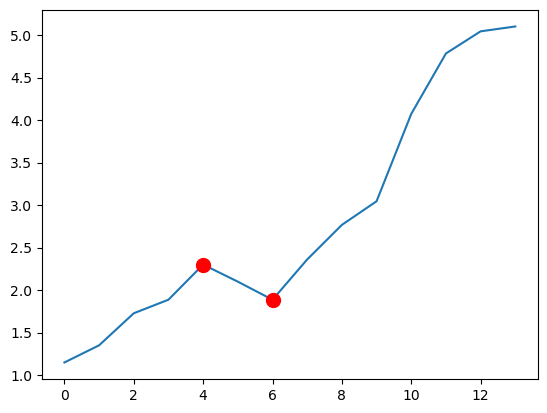

In [58]:
max_dd(SPY['strategy'].values[:-2])

In [59]:
max_drawdown(SPY['strategy'].values[:-2])

0.4137213065861638

In [50]:
returns = SPY['strategy']
returns.to_pickle('ada_returns.pkl')

In [53]:
rf_returns = pd.read_pickle('rf_strategy.pkl')

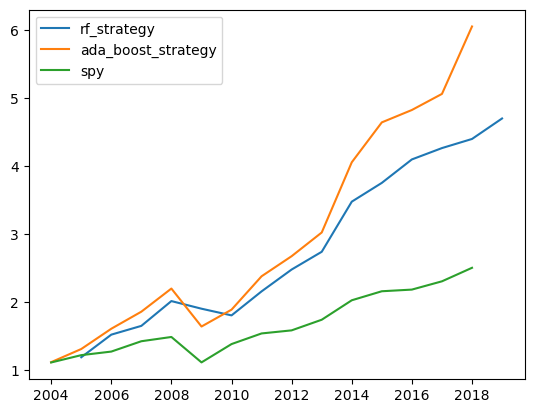

In [54]:
plt.plot(rf_returns['strategy'][1:],label='rf_strategy');
plt.plot(SPY['strategy'],label='ada_boost_strategy');
plt.plot(SPY['spy_cum_ret'],label='spy')
plt.legend()

In [55]:
combined = 0.7 *rf_returns['strategy'].values + 0.3 * returns.values

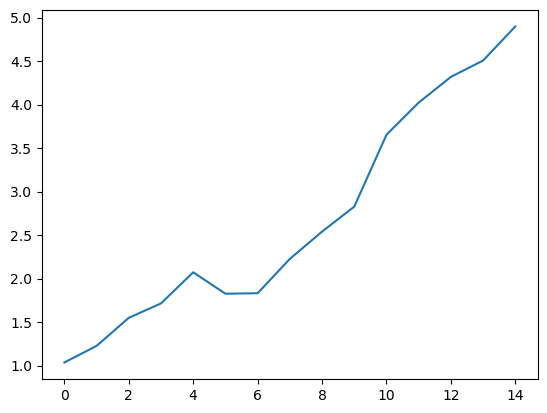

In [56]:
plt.plot(combined);

0.1587212383261234
0.37378500000000003


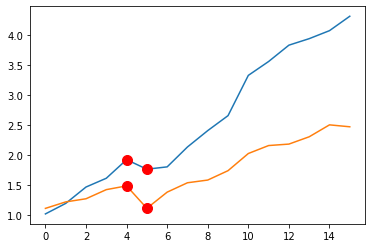

In [51]:
max_dd(combined)
max_dd(SPY['spy_cum_ret'].values)

In [62]:
combined_mean_ret = (np.diff(combined - 1)[:-1]).mean()
combined_std = (np.diff(combined - 1)[:-1]).std()
combined_sr = combined_mean_ret/(combined_std)
print('Combined Sharpe Ratio: ',combined_sr)

Combined Sharpe Ratio:  1.2148590458219228


In [61]:
combined

array([1.03539968, 1.22661266, 1.54901176, 1.71443438, 2.07177349,
       1.82577569, 1.8313456 , 2.22583342, 2.53920615, 2.82667024,
       3.65239395, 4.0216951 , 4.31763086, 4.50570607, 4.89694153,
              nan])

In [64]:
strategy_ret = np.diff(combined - 1)[:-1]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:-1]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

1.0360015553158246